<a href="https://colab.research.google.com/github/Temmybjt/Store-Sales--Time-Series-Forecasting/blob/main/Store_Sales_Time_Series_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Store Sales - Time Series Forecasting**

Build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores with an approachable training dataset of dates, store, and item information, promotions, and unit sales.

In [13]:
# Libraries
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt; plt.style.use('ggplot')

import plotly.express as px

import warnings; warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# Import the main analysis datasets

In [6]:
# Check the training and test dataframes
train_data = pd.read_csv('/home/StoreSales/train.csv.zip')
test_data = pd.read_csv('/home/StoreSales/test.csv')

print('The dimension of the train dataset is:', train_data.shape)
print('The dimension of the test dataset is:', test_data.shape)

The dimension of the train dataset is: (3000888, 6)
The dimension of the test dataset is: (28512, 5)


In [7]:
# Work with a copy of the orinal data always
train = train_data.copy()
test = test_data.copy()

In [8]:
train.head(2)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0


In [9]:
train.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [11]:
test.describe()

,id,store_nbr,onpromotion
count,2.851200e+04,28512.000000,28512.000000
mean,3.015144e+06,27.500000,6.965383
std,8.230850e+03,15.586057,20.683952
min,3.000888e+06,1.000000,0.000000
25%,3.008016e+06,14.000000,0.000000
50%,3.015144e+06,27.500000,0.000000
75%,3.022271e+06,41.000000,6.000000
max,3.029399e+06,54.000000,646.000000


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


# Import supporting datasets

In [14]:
holidays = pd.read_csv('/home/StoreSales/holidays_events.csv')
stores = pd.read_csv('/home/StoreSales/stores.csv')
transactions = pd.read_csv('/home/StoreSales/transactions.csv.zip')
oil = pd.read_csv('/home/StoreSales/oil.csv')

In [15]:
holidays.describe()

,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338


In [16]:
stores.describe()

,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


In [17]:
transactions.describe()

,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


In [18]:
oil.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


In [19]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


# Merge datasets on common feature

In [20]:
# Merge oil price
train = train.merge(oil, on='date', how='left')
test = test.merge(oil, on='date', how='left')

# Merge transactions
train = train.merge(transactions, on=['date', 'store_nbr'], how='left')
test = test.merge(transactions, on=['date', 'store_nbr'], how='left')

# Merge stores description
train = train.merge(stores, on='store_nbr', how='left')
test = test.merge(stores, on='store_nbr', how='left')


In [21]:
# Merge holidays after removing transferred holidays
# Remove transferred (true) holidays
holidays.head(2)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False


In [22]:
# Remove transferred (true) holidays
holidays = holidays.loc[holidays.iloc[:, -1] != "True"]

In [23]:
# Add holidays
train = train.merge(holidays, on='date', how='left')
test = test.merge(holidays, on='date', how='left')

In [24]:
train.head(2)

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,transactions,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False


In [25]:
train.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
dcoilwtico       955152
transactions     249117
city                  0
state                 0
type_x                0
cluster               0
type_y          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

# Data Exploration

In [28]:

# check for products  sold
train['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [26]:
# Create columns for holidays(Local, Regional and National Holidays)
def nat_holiday(row):
  if row['locale'] == 'National':
    return 1
  else:
    return 0

def reg_holiday(row):
  if row['locale'] == 'Regional' and row['locale_name'] == row['state']:
    return 1
  else:
      return 0

def loc_holiday(row):
   if row['locale'] == 'Local' and row['locale_name'] == row['city']:
      return 1
   else:
    return 0


In [27]:
train['holiday_national'] = train.apply(nat_holiday, axis=1)
train['holiday_regional'] = train.apply(reg_holiday, axis=1)
train['holiday_local'] = train.apply(loc_holiday, axis=1)

test['holiday_national'] = test.apply(nat_holiday, axis=1)
test['holiday_regional'] = test.apply(reg_holiday, axis=1)
test['holiday_local'] = test.apply(loc_holiday, axis=1)

In [29]:
# Convert Date to datetime and create new columns
def datetime_conversion(df):
    df['date'] = pd.to_datetime(df["date"], format='%Y-%m-%d')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.day_of_week
    df['day_name'] = df['date'].dt.day_name()
    df['quarter'] = df['date'].dt.quarter
    return df

In [30]:
# Convert date to datetime for both test and train data
train = datetime_conversion(train)
test = datetime_conversion(test)

In [31]:
train.head(2)

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,transactions,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred,holiday_national,holiday_regional,holiday_local,year,month,day,day_of_week,day_name,quarter
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,1,0,0,2013,1,1,1,Tuesday,1
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,1,0,0,2013,1,1,1,Tuesday,1


In [32]:
# Characteristics of datasets
print(f'Number of observations: {test.shape[0]}\n Number of features: {train.shape[1]}')

Number of observations: 28512
 Number of features: 26


In [33]:
# TIme period covered by data
print(f'Time period covered by the data: {train.date.nunique()} days\n First day: {train.date[0]} || Last day: {train.date.iloc[-1]}')

Time period covered by the data: 1684 days
 First day: 2013-01-01 00:00:00 || Last day: 2017-08-15 00:00:00


In [34]:
print(f'Numbers of stores: {train.store_nbr.nunique()}')

Numbers of stores: 54


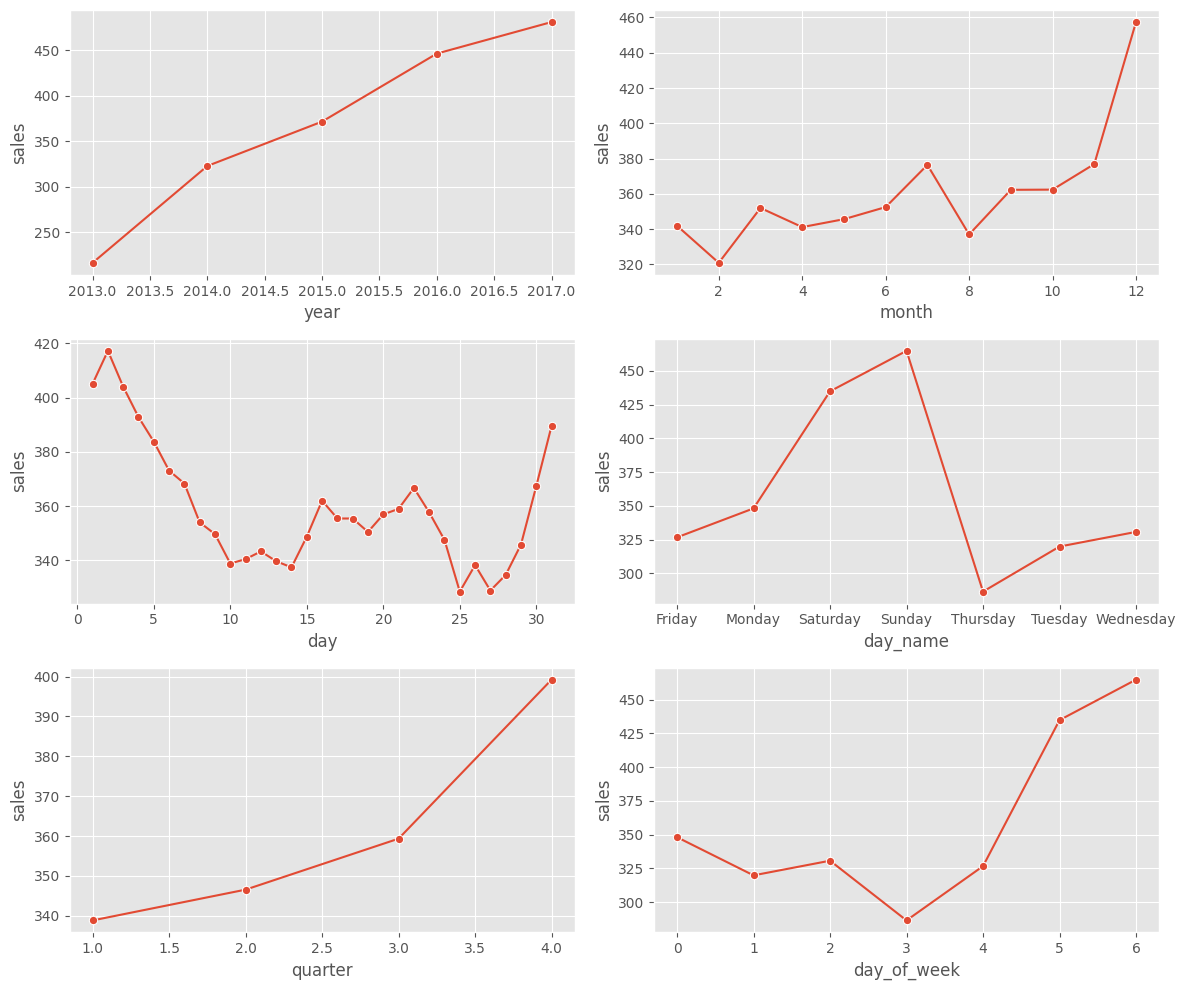

In [37]:
# Trends over time periods
grouping_columns = ['year', 'month', 'day', 'day_name', 'quarter', 'day_of_week']

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for ind, column in enumerate(grouping_columns):
    grouped_data = train.groupby(column)['sales'].mean()
    grouped_data = pd.DataFrame(grouped_data).reset_index()

    sns.lineplot(data=grouped_data, x=column, y='sales', ax=axes[ind], marker = 'o')

plt.tight_layout()
plt.show()

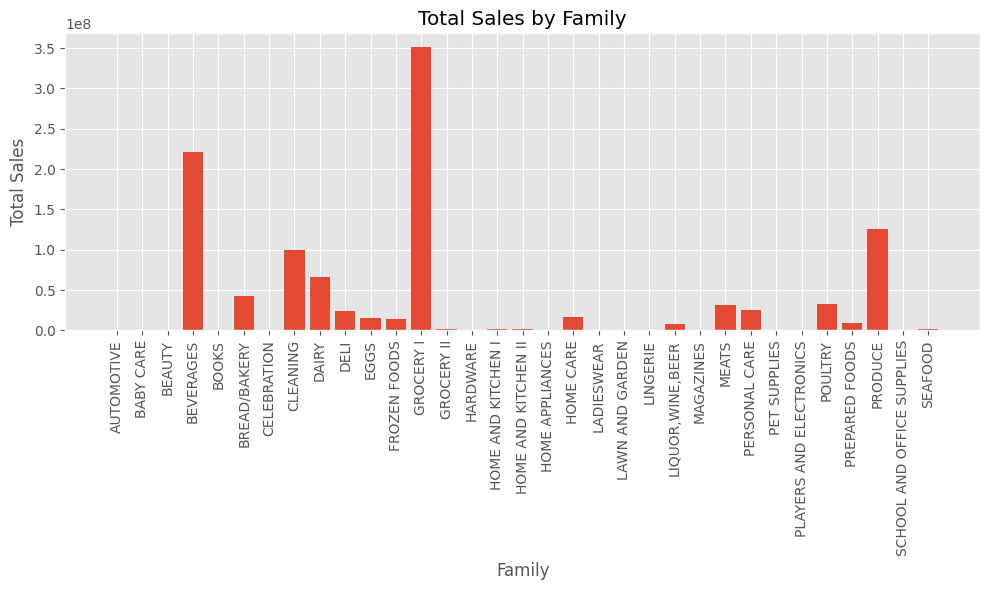

In [80]:
# Total Sales By Family of Products Sold
TotalSales_family = train.groupby('family')['sales'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(TotalSales_family['family'], TotalSales_family['sales'])
plt.xlabel('Family')
plt.ylabel('Total Sales')
plt.title('Total Sales by Family')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

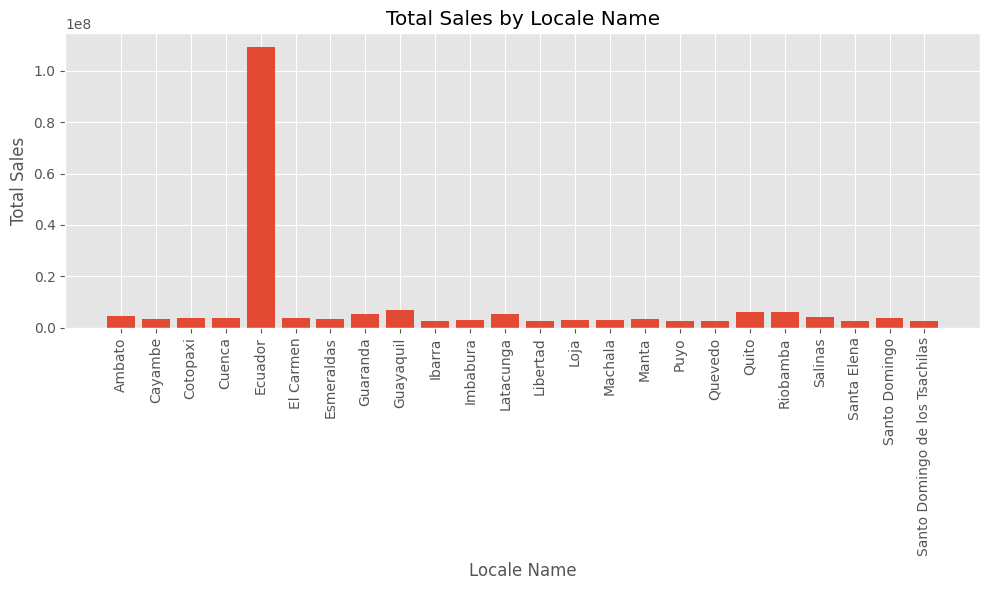

In [81]:
# Total Sales By Locale Name
grouped_by_locale_name = train.groupby('locale_name')['sales'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(grouped_by_locale_name['locale_name'], grouped_by_locale_name['sales'])
plt.xlabel('Locale Name')
plt.ylabel('Total Sales')
plt.title('Total Sales by Locale Name')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

# **Findings**

*   There are no sales on the first day of the year(each year).
*   There is increse in sales mid month on the average.
*   Saturday and Sundays( Weekends) have most sales recorded.



## Eliminate features that do not provide important data

*  **transactions:** general information does not seperate into products
*  **city, state:** information within clusters and type_x
*  **locale, locale_name, description:** information within holidays
*  **transferred: not relevant**





## **Data Preprocessing**

In [85]:
# Drop irrelevant columns from test and train data
train = train.drop(columns=['id','city', 'state', 'transactions', 'type_y', 'locale', 'locale_name', 'description', 'transferred'])
test = test.drop(columns=['id','city', 'state', 'transactions', 'type_y', 'locale', 'locale_name', 'description', 'transferred'])

In [86]:
train.tail(2)

,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,cluster,holiday_national,holiday_regional,holiday_local,year,month,day,day_of_week,day_name,quarter
3054346,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.0,8,47.57,B,6,0,0,0,2017,8,15,1,Tuesday,3
3054347,2017-08-15,9,SEAFOOD,16.0,0,47.57,B,6,0,0,0,2017,8,15,1,Tuesday,3


In [87]:
test.head(2)

,date,store_nbr,family,onpromotion,dcoilwtico,type_x,cluster,holiday_national,holiday_regional,holiday_local,year,month,day,day_of_week,day_name,quarter
0,2017-08-16,1,AUTOMOTIVE,0,46.8,D,13,0,0,0,2017,8,16,2,Wednesday,3
1,2017-08-16,1,BABY CARE,0,46.8,D,13,0,0,0,2017,8,16,2,Wednesday,3


In [88]:
# Check for missing values and fill
print(train.isna().sum().sort_values(ascending=False))

dcoilwtico          955152
date                     0
holiday_regional         0
day_name                 0
day_of_week              0
day                      0
month                    0
year                     0
holiday_local            0
holiday_national         0
store_nbr                0
cluster                  0
type_x                   0
onpromotion              0
sales                    0
family                   0
quarter                  0
dtype: int64


In [89]:
# Use the next lowest value first and then the next highest value for both test and training data
train['dcoilwtico'] = train['dcoilwtico'].fillna(method='bfill')
train['dcoilwtico'] = train['dcoilwtico'].fillna(method='ffill')

test['dcoilwtico'] = test['dcoilwtico'].fillna(method='bfill')
test['dcoilwtico'] = test['dcoilwtico'].fillna(method='ffill')

In [90]:
print(train.isna().sum().sort_values(ascending=False))

date                0
holiday_regional    0
day_name            0
day_of_week         0
day                 0
month               0
year                0
holiday_local       0
holiday_national    0
store_nbr           0
cluster             0
type_x              0
dcoilwtico          0
onpromotion         0
sales               0
family              0
quarter             0
dtype: int64


In [91]:
print(test.isna().sum().sort_values(ascending=False))

date                0
store_nbr           0
family              0
onpromotion         0
dcoilwtico          0
type_x              0
cluster             0
holiday_national    0
holiday_regional    0
holiday_local       0
year                0
month               0
day                 0
day_of_week         0
day_name            0
quarter             0
dtype: int64


In [92]:
train.dtypes

date                datetime64[ns]
store_nbr                    int64
family                      object
sales                      float64
onpromotion                  int64
dcoilwtico                 float64
type_x                      object
cluster                      int64
holiday_national             int64
holiday_regional             int64
holiday_local                int64
year                         int64
month                        int64
day                          int64
day_of_week                  int64
day_name                    object
quarter                      int64
dtype: object

## **Build Model**

In [93]:
# categorical columns
cat_cols = ['family', 'type_x']